# Feature Engineering: Building the `aid_demand` Target

Goal: Create a composite target `aid_demand` that reflects how much relief a district needs.
We will:
1) Clean/standardize column names (optional but recommended),
2) Scale the indicators to a common range (0–1) so they are comparable,
3) Combine them into `aid_demand` using (a) equal weights (MVP) and (b) priority weights (optional),
4) Inspect rankings and correlations to understand what drives `aid_demand`.


## Load the Kerala 2018 dataset

We load the same CSV we used in EDA


In [1]:
import pandas as pd
df=pd.read_csv("../data/kerala_floods_2018.csv")
df.head()


,district,fatalities,no_of_camps,actual_rainfall_in_mm,normal_rainfall_in_mm,no_of_landslides,full_damaged_houses
0,Thiruvananthapuram,11,94,373.8,142.0,0,111
1,Kollam,5,168,644.1,258.7,2,95
2,Pathanamthitta,3,4352,764.9,352.7,8,741
3,Alappuzha,43,2126,608.2,343.1,0,2075
4,Kottayam,14,788,619.2,386.0,29,76


## Choose indicators that represent "need"

We combine multiple indicators that signal demand for relief:
- `fatalities` → urgency (life impact)
- `camps` → displaced people needing food/shelter
- `full_damage`, `partial_damage` → infrastructure loss
- `landslides` → secondary hazards adding pressure

**Important**: These are *indicators*, not features for scaling rainfall yet. We’re building the target first.


In [7]:
need_cols = []
for cols in ["fatalities","no_of_camps","full_damaged_houses","no_of_landslides"]:
    if cols in df.columns:
        need_cols.append(cols)



## Scale indicators to a common 0–1 range (Min–Max)

Why: Raw values are on different scales (houses can be thousands, deaths are tens).  
Scaling to [0,1] ensures each indicator is comparable **before** we combine them.
x' = x-xmin/xmax-xmin


In [13]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[need_cols]=scaler.fit_transform(df[need_cols])
df_scaled[need_cols].head()


,fatalities,no_of_camps,full_damaged_houses,no_of_landslides
0,0.140845,0.021149,0.037422,0.000000
1,0.056338,0.038161,0.031878,0.013986
2,0.028169,1.000000,0.255717,0.055944
3,0.591549,0.488276,0.717949,0.000000
4,0.183099,0.180690,0.025295,0.202797


## Building `aid_demand` using Priority Weights

We combine the scaled disaster impact indicators into a single score **`aid_demand`**.

Since our dataset does **not** include `partial_damage`, we use the following columns:
- **Fatalities (0.45)** → highest priority, loss of life
- **Camps (0.30)** → displaced people needing urgent relief
- **Full damage (0.15)** → houses fully destroyed
- **Landslides (0.10)** → secondary hazards

Weights are chosen to reflect humanitarian priorities and sum to **1.0**.  


In [16]:
import numpy as np

priority_weights = {"fatalities":0.45,"no_of_camps":0.30,"full_damaged_houses":0.15,"no_of_landslides":0.10}
w=np.array([priority_weights[c] for c in need_cols])
df_scaled["aid_demand"] = (df_scaled[need_cols]*w).sum(axis=1)
df_scaled[["district","aid_demand"]].sort_values("aid_demand",ascending=False).head(10)

,district,aid_demand
7,Thrissur,0.722389
5,Idukki,0.521259
3,Alappuzha,0.520372
6,Ernakulam,0.502042
2,Pathanamthitta,0.356628
9,Malappuram,0.245165
8,Palakkad,0.203602
4,Kottayam,0.160675
10,Kozhikode,0.134149
11,Wayanad,0.131853


## Plotting Districts vs Aid Demand
- I am using a normal bar graph to plot this 

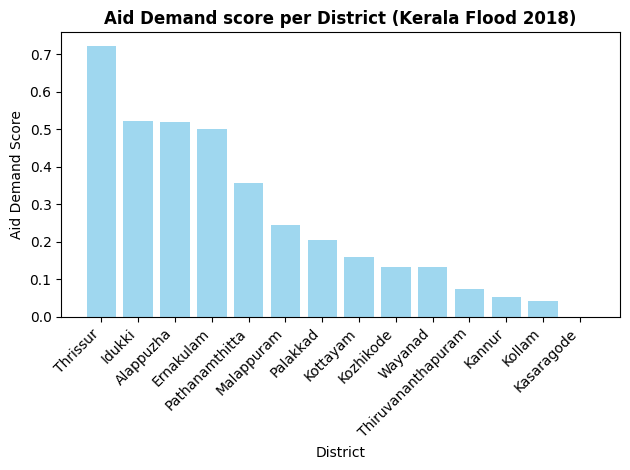

In [17]:
import matplotlib.pyplot as plt
plot_df = df_scaled.sort_values("aid_demand",ascending=False)
plt.bar(plot_df["district"],plot_df["aid_demand"],color="skyblue",alpha=0.8)
plt.title("Aid Demand score per District (Kerala Flood 2018)",fontweight="bold")
plt.xlabel("District")
plt.ylabel("Aid Demand Score")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

## Correlation Heatmap  

We use **Seaborn** (a Python visualization library) to create a heatmap of correlations.  
This helps us see how each factor (fatalities, camps, damages, landslides) relates to the computed **`aid_demand`** score.  


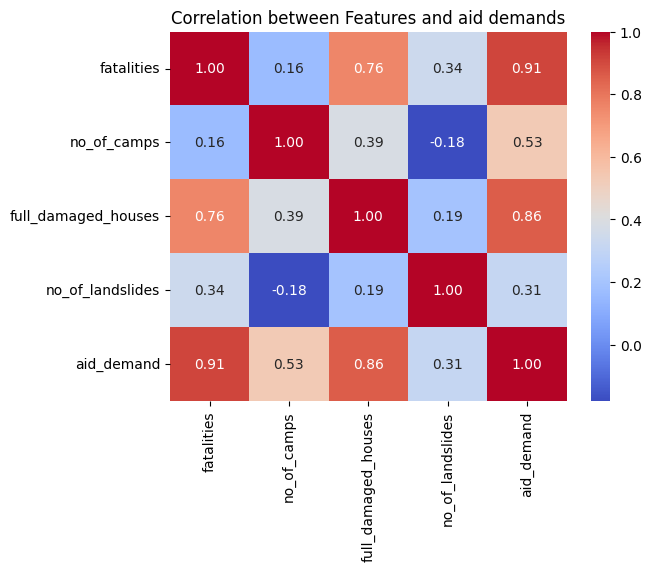

In [18]:
import seaborn as sns
sns.heatmap(df_scaled[need_cols+["aid_demand"]].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation between Features and aid demands")
plt.show()